Enter name(s) here: Andrew Vuong, Henry Wang, Aaron Johnson

# Group Project
 
The project aims to create a classification model to classify whether the person has cervical cancer or not based on a collection of data from a cohort study of cervical cytology with or without HPV mRNA biomarkers examined to detect cervical intraepithelial Neoplasia in young Norwegian women. There are two diagnostic test to determine the presence of cervical cancer, through a cervical cytology (pap smear) or an HPV mRNA DNA test. The problem is important to determine whether HPV mRNA biomarkers are significant enough to influence positively the sensitivity of cervical cancer screening. Needless to say, early detection is key to high survival rate in cancer patients and having a higher sensitivity would result in less false negatives. The model could be trained to predict whether the patient has cervical cancer given a set of features such as HPV mRNA biomarkers (SEE_01, SEE_16, SEE_18, and SEE_45) and the types of diagnostic study exam.

**FULL DISCLOSURE Based the Project's network on, our, Andrew Vuong and Henry's Solution for Professor Beasley's HW3**

In [24]:
#You may add additional imports
import warnings
#warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import random

In [25]:
%matplotlib inline

### Data Prep - Fill missing value using a generated distribution based on similiar non missing values

In [26]:
# Read the data from csv file

data = pd.read_csv("Quality_control_cervical_cytology.csv", delimiter='\t', header=0)

""" 
The following groupby() uses the features that all records have and use them as the key for 
a dict that will serve as a distribution dict used to fill missing mRNA values.
Using the mean on binary values will yield probability that the missing values are 1 (pos) or 0 (neg).
"""
df_full = data.groupby(['study_gr', 'study_gr1', 'Diag_cyt', 'Diag_cyt_rev'])
df_full_prob = df_full.mean()

print(df_full_prob)
# print(df_full_prob.keys())

count = 0
for i,row in data.iterrows():
    if row[5] != row[5]: # to check NaN, row[5] is the first of mRNA feature, if NaN means the record is missing mRNA test values
#         print(df_full_prob['SEE_01'][row[1]][row[2]][row[3]][row[4]])
        # generate record specific probability of the four missing mRNA features
        see_01_roll = random.uniform(0, 1)
        see_16_roll = random.uniform(0, 1)
        see_18_roll = random.uniform(0, 1)
        see_45_roll = random.uniform(0, 1)
        # index in to distribution based on respective keys and set value based on probability
        see_01_val = 1 if see_01_roll < df_full_prob['SEE_01'][row[1]][row[2]][row[3]][row[4]] else 0
        see_16_val = 1 if see_16_roll < df_full_prob['SEE_16'][row[1]][row[2]][row[3]][row[4]] else 0
        see_18_val = 1 if see_18_roll < df_full_prob['SEE_18'][row[1]][row[2]][row[3]][row[4]] else 0
        see_45_val = 1 if see_45_roll < df_full_prob['SEE_45'][row[1]][row[2]][row[3]][row[4]] else 0
        # add to missing values to dataset
        data.at[i,'SEE_01'] = see_01_val
        data.at[i,'SEE_16'] = see_16_val
        data.at[i,'SEE_18'] = see_18_val
        data.at[i,'SEE_45'] = see_45_val
        count += 1
print(data.head(100))
data.to_csv(r'filledmissing.csv') # save to a new csv that includes filled in missing mRNA values for a complete dataset


                                                Age    SEE_01    SEE_16  \
study_gr study_gr1 Diag_cyt Diag_cyt_rev                                  
1        1         -1       -1            29.500000       NaN       NaN   
                    0        0            31.565652  0.000000  0.000000   
2        2          0        0            31.639831  0.000000  0.000000   
         3          0        1            29.166667  1.000000  0.791667   
                             2            29.000000  1.000000  1.000000   
                             4            28.500000  1.000000  0.500000   
                             5            39.000000  1.000000  0.000000   
3        4          1        1            29.870270  0.248322  0.127517   
                    2        2            29.109756  0.484848  0.212121   
4        5          3        3            31.085714  0.909091  0.818182   
                    4        4            29.375000  0.933333  0.733333   
                    5    

### Separating Data set into dataonly and labels. Label bins grades of positive and negative into binary classification of simply positive and negative

In [27]:

dataonly = data.drop(['biop_status'], axis=1)
# print(dataonly)
labels = data['biop_status'].apply(lambda x: 1 if int(x) > 20 else 0).ravel()
# labels = data['biop_status'].values.ravel()
# print(labels)

print(dataonly.shape)
print(dataonly.head(10))
print(labels)
##################################################################################

(4366, 10)
   Age  study_gr  study_gr1  Diag_cyt  Diag_cyt_rev  SEE_01  SEE_16  SEE_18  \
0   34         1          1         0             0     0.0     0.0     0.0   
1   31         1          1         0             0     0.0     0.0     0.0   
2   25         1          1         0             0     0.0     0.0     0.0   
3   33         1          1         0             0     0.0     0.0     0.0   
4   27         1          1         0             0     0.0     0.0     0.0   
5   24         1          1         0             0     0.0     0.0     0.0   
6   30         1          1         0             0     0.0     0.0     0.0   
7   26         1          1         0             0     0.0     0.0     0.0   
8   30         1          1         0             0     0.0     0.0     0.0   
9   38         1          1         0             0     0.0     0.0     0.0   

   SEE_45  Ind_biop  
0     0.0         0  
1     0.0         1  
2     0.0         1  
3     0.0         0  
4     0.0

### Decision Trees & Cross Validation

**Train/Test Split**

In [28]:
from sklearn.model_selection import train_test_split  #, DecisionTreeClassifier
train_x, test_x, train_y, test_y = train_test_split(dataonly, labels, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(3492, 10)
(874, 10)
(3492,)
(874,)


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(random_state=0, criterion='gini') 
dtree.fit(train_x, train_y)
prediction = dtree.predict(test_x)
print("for random state=0 and using gini: {}".format(accuracy_score(prediction, test_y)))
dtree = DecisionTreeClassifier(random_state=0, criterion='entropy') 
dtree.fit(train_x, train_y)
prediction = dtree.predict(test_x)
print("for random state=0 and using entropy: {}".format(accuracy_score(prediction, test_y)))
dtree = DecisionTreeClassifier(random_state=42, criterion='gini') 
dtree.fit(train_x, train_y)
prediction = dtree.predict(test_x)
print("for random state=42 and using gini: {}".format(accuracy_score(prediction, test_y)))


for random state=0 and using gini: 0.9553775743707094
for random state=0 and using entropy: 0.9553775743707094
for random state=42 and using gini: 0.954233409610984


**Cross Validation**

In [30]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(dtree, dataonly, labels, cv=10, n_jobs=-1))

[0.91324201 0.96118721 0.95881007 0.97254005 0.96559633 0.93577982
 0.9587156  0.98165138 0.98623853 0.18348624]


**Nested Cross Validation**

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets
max_depth = [5,10,15,20]
min_samples_leaf = [5,10,15,20]
max_features = [2,4,6,8,10]
param_grid = {'max_depth':max_depth, 'min_samples_leaf': min_samples_leaf, 'max_features':max_features}
cv = 5
dtreeGSCV = GridSearchCV(dtree,param_grid,cv=cv)
dtreeGSCV.fit(train_x, train_y)
print('The scikit-learn version is {}\n'.format(sk.__version__))
print("best parameters:\nmax_depth: {}\nmax_features: {}\nmin_samples_leaf: {}\n".format(\
dtreeGSCV.best_params_['max_depth'],\
dtreeGSCV.best_params_['max_features'],\
dtreeGSCV.best_params_['min_samples_leaf']))
print("best score: {}".format(dtreeGSCV.best_score_))

The scikit-learn version is 0.21.3

best parameters:
max_depth: 10
max_features: 6
min_samples_leaf: 10

best score: 0.9639175257731959


In [32]:
print(cross_val_score(dtreeGSCV, train_x, train_y, cv=10, n_jobs=-1))

[0.97142857 0.96857143 0.96275072 0.95988539 0.96848138 0.95415473
 0.96848138 0.95702006 0.94842407 0.97707736]


### Naive Bayes & Evaluation Metrics

In [33]:
from sklearn.naive_bayes import GaussianNB # then cross_val_score
modelNB = GaussianNB()
modelNB.fit(train_x, train_y)
print(cross_val_score(modelNB, train_x, train_y, cv=10, n_jobs=-1))


[0.94857143 0.92857143 0.9512894  0.94269341 0.94555874 0.92550143
 0.93982808 0.9512894  0.93696275 0.94842407]


In [34]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_predict


predict = cross_val_predict(modelNB, train_x, train_y, cv=10, n_jobs=-1)
true = train_y
print("Confusion Matrix:\n{}\n".format(confusion_matrix(true, predict)))
print("Classification Report:\n{}\n".format(classification_report(true, predict)))


Confusion Matrix:
[[3143  159]
 [  44  146]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3302
           1       0.48      0.77      0.59       190

    accuracy                           0.94      3492
   macro avg       0.73      0.86      0.78      3492
weighted avg       0.96      0.94      0.95      3492




roc_auc_score: 0.9470564074479737


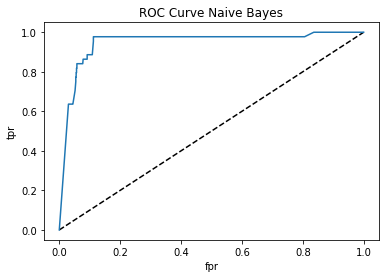

In [35]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm.libsvm import predict_proba
# train_x, test_x, train_y, test_y split already above

modelNB.fit(train_x, train_y)

predict_proba_results = modelNB.predict_proba(test_x)
# print(predict_proba_results)

#replace these fpr and tpr with the results of your roc_curve
fpr, tpr, thres = [], [], []
fpr, tpr, thres = roc_curve(test_y, predict_proba_results[:,1])
# print(predict_proba_results[:,1])
# print((predict_proba_results))
print("roc_auc_score: {}".format(roc_auc_score(test_y, predict_proba_results[:,1])))
# Do not change this code! This plots the ROC curve.
# Just replace the fpr and tpr above with the values from your roc_curve
plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()

### k-Nearest Neighbor (KNN)

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pca = PCA()
knc = KNeighborsClassifier(n_neighbors=7)
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('pca', PCA()), 
                       ('knc', KNeighborsClassifier(n_neighbors=7))])
print(cross_val_score(pipe, train_x, train_y, cv=5, n_jobs=-1))

[0.96137339 0.95851216 0.95702006 0.95845272 0.95845272]


In [37]:
'''
On the "pca" part of the pipeline, 
tune the n_components parameter,
by trying the values 1-19.

On the "knn" part of the pipeline, 
tune the n_neighbors parameter,
by trying the values 1-30.
'''
# print(pipe.get_params().keys())
param_grid = {
    'pca__n_components': list(range(2, 10)),
    'knc__n_neighbors': list(range(1, 25))
}
cv = 5
knnGSCV = GridSearchCV(pipe,param_grid,cv=cv)
knnGSCV.fit(train_x, train_y)
print('The scikit-learn version is {}\n'.format(sk.__version__))
print("best parameters:\n'pca_ncomponents': {}\n'knc_nneighbors': {}\n".format(\
knnGSCV.best_params_['pca__n_components'],\
knnGSCV.best_params_['knc__n_neighbors']))
print("best score: {}".format(knnGSCV.best_score_))



The scikit-learn version is 0.21.3

best parameters:
'pca_ncomponents': 7
'knc_nneighbors': 3

best score: 0.9621993127147767


In [38]:
print(cross_val_score(knnGSCV, train_x, train_y, cv=5, n_jobs=-1).mean())

0.95904874339519


### Support Vector Machine

In [39]:
from sklearn.svm import SVC

ss = StandardScaler()
svc = SVC(gamma='auto')

scaled = ss.fit_transform(dataonly)

pred = cross_val_predict(svc, scaled, labels, cv=10)

print("Classification Report:\n{}\n".format(classification_report(train_y, predict)))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3302
           1       0.48      0.77      0.59       190

    accuracy                           0.94      3492
   macro avg       0.73      0.86      0.78      3492
weighted avg       0.96      0.94      0.95      3492




### Neural Network

In [40]:
from sklearn.neural_network import MLPClassifier

warnings.simplefilter("ignore")
scaler = StandardScaler()
mlp = MLPClassifier()
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('mlp', MLPClassifier())])

param_grid = {
    'mlp__hidden_layer_sizes': list(range(30,60,10)),
    'mlp__activation': ['logistic', 'tanh', 'relu']
}

cv = 5
mlpGSCV = GridSearchCV(pipe,param_grid,cv=cv)
mlpGSCV.fit(train_x, train_y)

print("best score: {}".format(mlpGSCV.best_score_))

best score: 0.9656357388316151


### Ensemble Classifiers

In [41]:
from sklearn.ensemble import RandomForestClassifier

max_depth = list(range(35,56))
min_samples_leaf = [8, 10, 12]
max_features = ['sqrt', 'log2']
param_grid = {'max_depth':max_depth, 'min_samples_leaf': min_samples_leaf, 'max_features':max_features}
cv = 5
rfcGSCV = GridSearchCV(dtree,param_grid,cv=cv)
rfcGSCV.fit(train_x, train_y)
print('The scikit-learn version is {}\n'.format(sk.__version__))
print("best parameters:\nmax_depth: {}\nmax_features: {}\nmin_samples_leaf: {}\n".format(\
rfcGSCV.best_params_['max_depth'],\
rfcGSCV.best_params_['max_features'],\
rfcGSCV.best_params_['min_samples_leaf']))
print("cross val score: {}".format(cross_val_score(rfcGSCV, train_x, train_y, cv=5, n_jobs=-1)))


The scikit-learn version is 0.21.3

best parameters:
max_depth: 35
max_features: sqrt
min_samples_leaf: 10

cross val score: [0.96137339 0.96280401 0.95988539 0.95415473 0.95988539]


**AdaBoost**

In [42]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=150, random_state=0)
ada.fit(train_x, train_y)  
print(cross_val_score(ada, train_x, train_y, cv=5, n_jobs=-1).mean())

0.964204286926473
